## Generate data structures and detailed result files

In [4]:
'''
@author: Matthias Samwald, Medical University of Vienna
@author: Sebastian Hofer, Medical University of Vienna
'''

# IMPORTS

import itertools
#import vcf
import pprint
from collections import defaultdict
import xml.etree.ElementTree as et
import re
import sys
from collections import ChainMap, Counter
from IPython import parallel
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import pylab
import pickle
from functools import *


# MAGIC

%matplotlib inline


# CONSTANTS

# Debug mode on or off?
DEBUG = True

# database root directory
DBDIR = '../databases/'
# output root directory
OUTDIR = 'output/'

# a list of genes that are relevant for the analysis
GENES = ['CYP2C9', 'CYP2C19', 'CYP3A5', 'DPYD', 'SLCO1B1', 'TPMT', 'VKORC1']
# a list of assays that are relevant for the analysis
ASSAYS = ['hypothetical_assay_covering_all_rsids_in_pharmgkb', 'florida_stanford_chip', 'dmet_plus', 'taqman', 'veracode_adme_corepanel']
# a list of only the "real" assays
REAL_ASSAYS = ['florida_stanford_chip', 'dmet_plus', 'taqman', 'veracode_adme_corepanel']
# a random pick among the 1000genome samples -- used to check which rsids are covered in the data and which are not
THOUSAND_GENOMES_EXAMPLE_ID = 'HG00096'
# existing superpopulations
SUPERPOPULATIONS = ['AFR', 'AMR', 'ASN', 'EUR', 'SAN']

# full forms (expansions) of the abbreviations for assays, ...
EXP = {'FULL': 'hypothetical_assay_covering_all_rsids_in_pharmgkb',
       'FLOR': 'florida_stanford_chip',
       'DMET': 'dmet_plus',
       'TAQM': 'taqman',
       'VERA': 'veracode_adme_corepanel'}
# abbreviations
ABBR = {v: k for k, v in EXP.items()}

# gene symbol to ENSG identifier
GENE_TO_ENSG = {'CYP2C9': 'ENSG00000138109',
                'CYP2C19': 'ENSG00000165841',
                'CYP3A5': 'ENSG00000106258',
                'VKORC1': 'ENSG00000167397',
                'TPMT': 'ENSG00000137364',
                'DPYD': 'ENSG00000188641',
                'SLCO1B1': 'ENSG00000134538'}
ENSG_TO_GENE = {v: k for k, v in GENE_TO_ENSG.items()}

In [1]:
# FUNCTIONS

autodefaultdict = lambda: defaultdict(autodefaultdict)

prettyautodefaultdict = lambda: prettydefaultdict(prettyautodefaultdict)


class prettydefaultdict(defaultdict):
    """ A defaultdict that uses the standard python dict representation. """
    # see http://stackoverflow.com/questions/12925052/python-and-default-dict-how-to-pprint
    __repr__ = dict.__repr__


def convert_nested_defaultdict(dd):
    """ 
    Convert a defaultdict back into a native dictionary.
    Works for nested defaultdicts and prettydefaultdicts as well.
    """
    return {k: convert_nested_defaultdict(v) for k, v in dd.items()} if isinstance(dd, defaultdict) else dd


def debug(*args, **kwargs):
    """ Print to stdout only if DEBUG is True. """
    if DEBUG:
        print(*args, **kwargs)


def get_old_rsid_to_newest_rsid(path):
    """
    Return a map from old/depracated rsids to newest rsids, based on dbSNP rsid merge history.
    We need to do this because some assay descriptions use outdated rsids.
    """
    # will contain a map from old/depracated rsids to newest rsids, based on dbSNP rsid merge history
    old_rsid_to_newest_rsid = {}
    root = et.parse(path).getroot()
    
    # parse the dbSNP merge history xml file
    for rs_entry in root.findall('.//{http://www.ncbi.nlm.nih.gov/SNP/docsum}Rs'):
        for merge_history in rs_entry.findall('.//{http://www.ncbi.nlm.nih.gov/SNP/docsum}MergeHistory'):
            old_rsid_to_newest_rsid['rs' + merge_history.attrib['rsId']] = 'rs' + rs_entry.attrib['rsId'] 
            
    return old_rsid_to_newest_rsid


def get_rsid_to_reference_base(path):
    """ Return a map from rsid to the variant of that SNP found in the reference genome (GRCh37). """
    with open(path) as f:
        return {line.split()[0].strip(): line.split()[1].strip() for line in f}


def get_pseudo_hgvs_to_rsid(path):
    """ Return a map from pseudo hgvs identifiers to rsids. """
    # will contain a map from 'pseudo-HGVS' notation found in PharmGKB tables to rsid
    pseudo_hgvs_to_rsid = dict()   
    root = et.parse(path).getroot()
    #print(set(root.findall('.//{http://www.ncbi.nlm.nih.gov/SNP/docsum}Rs')))

    for rs_entry in root.findall('.//Rs'):
        fxn_set = rs_entry.find('.//FxnSet')
        if fxn_set != None:
            gene = fxn_set.attrib['symbol']
            for hgvs in rs_entry.findall('.//hgvs'):
                # match hgvs values with a form like 'NM_024006.4:c.*134G>A' (matching '134G>A')
                match = re.search(':c\.(.*)', hgvs.text)
                if match:
                    #print(hgvs.text)
                    # create pseudo-HGVS notation mapping, e.g., {'CYP2C19:134G>A': 'rs123456'}
                    pseudo_hgvs_to_rsid[gene + ':' + match.group(1)] = 'rs' + rs_entry.attrib['rsId']
                #pseudo_hgvs_to_rsid['rs' + merge_history.attrib['rsId']] = 'rs' + rs_entry.attrib['rsId']
                
    debug('pseudo_hgvs_to_rsid contains', len(pseudo_hgvs_to_rsid), 'mappings')
    
    return pseudo_hgvs_to_rsid


def get_haplotype_table(path):
    """ Return a table (actually just the files contents) of haplotype definitions. """
    with open(path) as f:
        return f.read()


def get_assay_to_rsids(path):
    """ Return a map from assays to the rsids covered by that assay. """
    assay_to_rsid_coverage = dict()
    # a blacklist to filter rsids. note that everything is lowercase
    blacklist = ['n/a', 'none']

    for assay in ASSAYS:
        if assay == EXP['FULL']:
            assay_to_rsid_coverage[assay] = set()  # this will be filled later on based on data from PharmGKB
        else:
            assay_to_rsid_coverage[assay] = set([rsid.strip()
                                                 for rsid in open(path + assay + '_rsids')
                                                 if rsid.strip().lower() not in blacklist])
            
    return assay_to_rsid_coverage


def get_gene_to_haplotype_to_rsid_to_base(genes):
    """ TODO: write docstring """
    global assay_to_rsids  # we need to add data for FULL view here
    
    # will capture definitions of alleles/haplotypes for our genes
    gene_to_haplotype_to_rsid_to_base = defaultdict(lambda: defaultdict())
    
    # read haplotype definition files
    gene_to_haplotype_table = {gene: get_haplotype_table(DBDIR + 'gene_definitions/' + gene) for gene in genes}

    # read haplotype table data into nested dictionary
    for gene, table in gene_to_haplotype_table.items():
        table = table.replace(" [tag]", "")  # remove [tag] information for now...
        for i, line in enumerate(table.splitlines()):
            if i == 0:
                header_array = list(map(str.strip, line.split("\t")))
                # subsitute polymorphism identifiers in pseudo-HGVS notation with likely dbSNP identifier 
                # (note: we found that some of the polymorphisms in the PharmGKB tables were not described by dbSNP identifiers even though they were available)
                for i, value in enumerate(header_array):
                    value_as_pseudo_hgvs = gene + ':' + value.strip()
                    if value_as_pseudo_hgvs in set(pseudo_hgvs_to_rsid.keys()):
                        debug('Substituting polymorphism', value, 'with rs identifier', pseudo_hgvs_to_rsid[value_as_pseudo_hgvs])
                        header_array[i] = pseudo_hgvs_to_rsid[value_as_pseudo_hgvs]
            else:
                line_array = line.split("\t")
                snps = {}

                # from this column on, rsid data can be found (to the left, there is the name of the haplotype etc)
                rsid_start_at_column = 3
                for index, rsid in enumerate(header_array[rsid_start_at_column:]):
                    rsid = rsid.strip()
                    if (rsid[0:2] == "rs"):  # only add if this is an rs number and not some other identifier
                        if rsid in set(old_rsid_to_newest_rsid.keys()):
                            rsid = old_rsid_to_newest_rsid[rsid]
                        assay_to_rsids[EXP['FULL']].add(rsid)
                        # only add rsid:variant pair if there actually is an entry in the table
                        if line_array[index + rsid_start_at_column] != "":
                            snps[rsid] = line_array[index + rsid_start_at_column].strip()

                gene_to_haplotype_to_rsid_to_base[line_array[0].strip()][line_array[2].strip()] = snps
                # {'UGT1A1': {'*60c': {'rs4148323': 'G', 'rs1057911': 'A'}}}

    return convert_nested_defaultdict(gene_to_haplotype_to_rsid_to_base)


def dump_gene_to_haplotype_to_rsid_to_base(path):
    """ Dump parsed gene definitions to file. """
    with open(path, 'w') as f:
        pprint.PrettyPrinter(indent=4, stream = f).pprint(gene_to_haplotype_to_rsid_to_base)
        

def get_assay_to_gene_to_haplotype_to_covered(genes):
    """ TODO: write docstring """
    # mapping of assays to the alleles covered by each assay
    assay_to_gene_to_haplotype_to_covered = autodefaultdict()
    
    for gene in genes:
        path = DBDIR + 'assay_allele_coverage/' + gene

        # read allele coverage data of various assays into nested dictionary
        with open(path) as f:
            header_array = f.readline().split("\t")

            for line in f:
                line_array = line.split("\t")
                haplotype = line_array[0].strip()
                
                for i, cell in enumerate(line_array):
                    if i == 0:  # skip haplotype column
                        continue

                    assay = header_array[i].strip()
                    value = cell.strip().lower()
                    
                    if assay in ASSAYS:  # add assay coverage information for the included assays
                        if value in ['x', '(x)', 'x*', '(assumed)']:
                            assay_to_gene_to_haplotype_to_covered[assay][gene][haplotype] = True
                        elif value == "":
                            assay_to_gene_to_haplotype_to_covered[assay][gene][haplotype] = False
                        else:
                            debug("Unrecogniced assay coverage for " + assay + " in gene " + gene + ": " + value)
                            assay_to_gene_to_haplotype_to_covered[assay][gene][haplotype] = False
                    
    return convert_nested_defaultdict(assay_to_gene_to_haplotype_to_covered)


def get_thousand_genomes_record_to_population(path):
    """ TODO: write docstring """
    map_thousand_genomes_record_to_population = dict()
    
    # read mapping from 1000genome records to populations
    for line in open(path):
        line_array = line.split("\t")
        if line_array[0]:
            map_thousand_genomes_record_to_population[line_array[0]] = line_array[1]    # mapping from record ID to population

    return map_thousand_genomes_record_to_population


def get_population_to_superpopulation(path):
    """ TODO: write docstring """
    population_to_superpopulation = dict()
    
    # read mapping from populations to superpopulations
    with open(path) as f:
        next(f)  # skip header line
        for line in f:
            line_array = line.split("\t")
            if line_array[0]:
                population_to_superpopulation[line_array[0]] = line_array[2]

    return population_to_superpopulation


def get_rsids_in_dbsnp():
    """ Return the rsids in rsids.tsv as a mapping from gene to rsids. """
    rsids_in_dbsnp = defaultdict(set)
    with open(DBDIR + 'dbsnp/rsids.tsv') as f:
        header_array = f.readline().strip().split("\t")
        header_to_column = {v: i for i, v in enumerate(header_array)}
        for line in f:
            line_array = line.strip().split("\t")
            rsid = line_array[header_to_column['Variation Name']]
            gene = ENSG_TO_GENE[line_array[header_to_column['Ensembl Gene ID']]]
            rsids_in_dbsnp[gene].add(rsid)
            
    return rsids_in_dbsnp


def get_thousand_genomes_samples(genes):
    """
    Return 1000Genomes samples haplotype information for the given gene.
    TODO: write better doc
    """
    
    # thousand genomes read data
    thousand_genomes_samples = autodefaultdict()
    # keep track of rsids in thousand genomes for every gene
    gene_to_rsids_in_thousand_genomes = {}
    # and also for all rsids encountered so far
    rsids_in_thousand_genomes = set()
    # keep track of rsids not found in 1000 genomes data for every gene # TODO: understand this better
    rsids_not_in_reference_genome = {}
    # get rsids in the coding region of the genes from dbSNP
    rsids_in_dbsnp = get_rsids_in_dbsnp()
    
    for gene in genes:
        print("Reading thousand genomes data for " + gene + "...")
        
        vcf_reader = vcf.Reader(open(DBDIR + '1000genomes/phase3/' + gene, 'r'))
        gene_to_rsids_in_thousand_genomes[gene] = set()
        rsids_not_in_reference_genome[gene] = set()

        for record in vcf_reader:
            rsid = record.ID
            
            # keep track of covered rsids, discard None entries
            if rsid != None:
                gene_to_rsids_in_thousand_genomes[gene].add(rsid)
            
            if rsid in assay_to_rsids['hypothetical_assay_covering_all_rsids_in_pharmgkb']:
                number_of_samples = len(record.samples)
                for call in record.samples:
                    sample_id = str(call.sample)  # thousand genome sample identifier
                    rsid = record.ID
                    maternal_variant, paternal_variant = call.gt_bases.split("|")
                    thousand_genomes_samples[sample_id][gene]['maternal_haplotype']['snps'][rsid] = maternal_variant # first variant is arbitrarily named 'maternal'
                    thousand_genomes_samples[sample_id][gene]['paternal_haplotype']['snps'][rsid] = paternal_variant # second variant is arbitrarily named 'paternal'
                    
                    # create empty structure to hold allele information inferred later on
                    for assay in ASSAYS:
                        for maternal_or_paternal_haplotype in ['maternal_haplotype', 'paternal_haplotype']:
                            thousand_genomes_samples[sample_id][gene][maternal_or_paternal_haplotype]['allele'][assay] = set()
        
        # print statistics about rsids
        rsids_in_haplotype_definition = set(gene_to_haplotype_to_rsid_to_base[gene]['*1'].keys())
        rsids_not_in_thousand_genomes = rsids_in_haplotype_definition - gene_to_rsids_in_thousand_genomes[gene]
        debug("Out of", len(rsids_in_haplotype_definition), "rsids used in the haplotype definition,",
              len(rsids_not_in_thousand_genomes), "were not found in 1000 Genomes data.")
        rsids_not_in_haplotype_definition = rsids_in_dbsnp[gene] - rsids_in_haplotype_definition
        debug("Out of", len(rsids_in_dbsnp[gene]), "SNPs in the gene,",
              len(rsids_not_in_haplotype_definition), "were not used in the haplotype definition.")
        
        # Extend 1000genome sample data by imputing rsids that were filtered from 1000genomes.
        # rsids are imputed based on variants in the reference genome. 
        # In rare cases where the SNPs is not defined for the reference genome, the variant of the *1 allele is used as a fallback.
        for sample in thousand_genomes_samples:
            for maternal_or_paternal_haplotype in ['maternal_haplotype', 'paternal_haplotype']:
                for rsid in rsids_not_in_thousand_genomes:
                    if rsid in rsid_to_reference_base.keys():
                        imputation_snp = rsid_to_reference_base[rsid]
                    else:
                        rsids_not_in_reference_genome[gene].add(rsid)  # keep track of not found rsids
                        imputation_snp = gene_to_haplotype_to_rsid_to_base[gene]['*1'][rsid]
                        

                    thousand_genomes_samples[sample][gene][maternal_or_paternal_haplotype]['snps'][rsid] = imputation_snp
        debug("rsids in haplotype definition, but not in 1000Genomes data and not in reference genome:", rsids_not_in_reference_genome[gene])
    
    rsids_in_thousand_genomes = set([y for x in gene_to_rsids_in_thousand_genomes.values() for y in x])
    
    return (convert_nested_defaultdict(thousand_genomes_samples), rsids_in_thousand_genomes)


def process_genes(genes):
    """ TODO: write doc """
    
    # list for capturing results of haplotype matching -- this is where the interesting data will be captured in
    results = list()
    
    for gene in genes:
        print('Processing ' + gene + '...')
        
        with open(OUTDIR + gene + '.txt', 'w') as f:
            ''' 
            For different lists of SNPs covered by different assays, group alleles into indistinguishable allels.    
            TODO: Compare that to alleles claimed to be discoverable by manufacturer.
            '''

            for assay, covered_rsids in assay_to_rsids.items():
                print("\n\n** ASSAY:", assay, "**", file = f)
                haplotypes = gene_to_haplotype_to_rsid_to_base[gene]

                count_overlapping = 0
                overlapping_haplotype_sets = list()
                # generate 'pruned' versions of the haplotypes that only contain rsids/SNPs covered by the specific assay (i.e., the intersection of rsids in the PharmGKB table and rsids covered by the assay), AS WELL AS BY 1000genomes DATASETS!
                pruned_haplotypes = dict()
                for haplotype_id, haplotype in haplotypes.items():
                    # original pruning algorithm: pruned_haplotypes[haplotype_id] = {rsid: haplotype[rsid] for rsid in set(covered_rsids & haplotype.keys() & thousand_genome_rsids)}
                    pruned_haplotypes[haplotype_id] = {rsid: haplotype[rsid] for rsid in set(covered_rsids & haplotype.keys() )}

                # check all combinations of these pruned haplotype definitions for overlaps
                for haplotype_id_1, haplotype_id_2 in itertools.combinations(pruned_haplotypes, 2):   
                    haplotype_1_snps = set(pruned_haplotypes[haplotype_id_1].items())
                    haplotype_2_snps = set(pruned_haplotypes[haplotype_id_2].items())
                    if haplotype_1_snps.issubset(haplotype_2_snps):
                        #count_overlapping += 1
                        found_existing_set_containing_at_least_one_of_the_overlapping_snps = False

                        # iterate through list of overlapping haplotypes already found, if one haplotype_id in the overlapping pair is already part of a set of overlapping haplotypes, add the pair to this set
                        for i, val in enumerate(overlapping_haplotype_sets):
                            if (haplotype_id_1 in val) or (haplotype_id_2 in val):
                                overlapping_haplotype_sets[i].add(haplotype_id_1)
                                overlapping_haplotype_sets[i].add(haplotype_id_2)
                                found_existing_set_containing_at_least_one_of_the_overlapping_snps = True
                        if not found_existing_set_containing_at_least_one_of_the_overlapping_snps:
                            overlapping_haplotype_sets.append({haplotype_id_1, haplotype_id_2})

                print(len(overlapping_haplotype_sets), "set(s) of mutually indistinguishable haplotypes (not considering haplotype constraints of assay): ", file = f)
                for overlapping_haplotype_set in overlapping_haplotype_sets:
                    print(sorted(overlapping_haplotype_set), file = f)
                print(len(pruned_haplotypes[haplotype_id_1].keys()), "rsids were used to define haplotypes for this gene", file = f)
                if assay != 'hypothetical_assay_covering_all_rsids_in_pharmgkb':
                    actually_covered_haplotypes = [key for key, value in assay_to_gene_to_haplotype_to_covered[assay][gene].items() if value]
                    print('The following', len(actually_covered_haplotypes), 'haplotypes are claimed to be covered by this assay:', file = f) 
                    print(sorted(actually_covered_haplotypes), file = f)
                    print('The following haplotypes are claimed to be covered by this assay, but are mutually indistinguishable based on the constrained haplotype definitions we use:', file = f) 
                    for overlapping_haplotype_set in overlapping_haplotype_sets:
                        overlapping_haplotype_set_filtered_by_coverage = sorted(overlapping_haplotype_set.intersection(actually_covered_haplotypes))
                        if len(overlapping_haplotype_set_filtered_by_coverage) > 1:
                            print(overlapping_haplotype_set_filtered_by_coverage, file = f)

                else:
                    print('All', len(gene_to_haplotype_to_rsid_to_base[gene].keys()), 'haplotypes in PharmGKB are covered by the hypothetical assay:', file = f)
                    print(sorted(gene_to_haplotype_to_rsid_to_base[gene].keys()), file = f)
            ''' 
            For different lists of SNPs covered by different assays, calculate how many samples in 1000genomes would be assigned an allele 
            that actually does not match the 'correct' allele ('correct' allele = the allele inferred based on 'hypothetical_assay_covering_all_rsids_in_pharmgkb'). 
            TODO: Also generate statistics on inferred alleles, ethnicities etc.
            '''

            # for each type of assay
            for assay, covered_rsids in assay_to_rsids.items():
                # iterate through all 1000genome samples
                for sample, sample_data in thousand_genomes_samples.items():
                    # iterate through genes of each sample
                    for cur_gene, gene_data in sample_data.items():
                        # generate 'pruned' versions of the PharmGKB haplotypes based on the limited set of rsids that can be obseverd by the assay
                        # TODO: the current implemntation is a bit inefficient, since we are redundantly generating pruned haplotype definitions for each new sample...
                        pruned_haplotypes = dict()
                        for haplotype_id, haplotype in gene_to_haplotype_to_rsid_to_base[cur_gene].items():
                            pruned_haplotypes[haplotype_id] = {rsid: haplotype[rsid] for rsid in set(covered_rsids & haplotype.keys() & gene_data['maternal_haplotype']['snps'].keys())}
                        # skip and print message if assay has no rsids of this gene at all (which probably means that the assay was not designed to test for this gene at all)
                        if len(pruned_haplotypes) == 0:
                            print("It seems like this assay covers no markers of this gene at all; skipping...", file = f)
                            continue
                        # print(pruned_haplotypes)
                        for maternal_or_paternal_haplotype in ['maternal_haplotype', 'paternal_haplotype']:
                            # iterate through all the pruned haplotypes and see if they are subsets of the haplotype found in the sample
                            for pruned_haplotype_id in pruned_haplotypes:
                                if set(pruned_haplotypes[pruned_haplotype_id].items()).issubset(set(gene_data[maternal_or_paternal_haplotype]['snps'].items())):
                                    assay_allele_coverage_status = assay_to_gene_to_haplotype_to_covered.get(assay, {}).get(cur_gene, {}).get(pruned_haplotype_id, "")
                                    if assay_allele_coverage_status or assay == EXP['FULL']:   # only call allele if it is among the callable alleles for this assay, or if we are examining the hypothetical assay
                                        #print(maternal_or_paternal_haplotype, "match:", pruned_haplotype_id, file = f)
                                        thousand_genomes_samples[sample][cur_gene][maternal_or_paternal_haplotype]['allele'][assay].add(pruned_haplotype_id)

            '''
            Generate statistics
            '''

            snp_frequency_data = autodefaultdict()  #    for example: {  'rs1057910': {   'count_in_gene_definitions': {'A': 32, 'C': 2},
                                                    #                                     'count_in_population_sample': {'A': 2091, 'C': 93}}}
            for haplotype_id in gene_to_haplotype_to_rsid_to_base[gene]:
                for rsid in gene_to_haplotype_to_rsid_to_base[gene][haplotype_id]:
                    # this is quite unelegant because of the way the autovivification dictionary works (inexistant values do not default to 0)
                    if isinstance(snp_frequency_data[rsid]['count_in_gene_definitions'][gene_to_haplotype_to_rsid_to_base[gene][haplotype_id][rsid]], int):
                        snp_frequency_data[rsid]['count_in_gene_definitions'][gene_to_haplotype_to_rsid_to_base[gene][haplotype_id][rsid]] += 1
                    else:
                        snp_frequency_data[rsid]['count_in_gene_definitions'][gene_to_haplotype_to_rsid_to_base[gene][haplotype_id][rsid]] = 1

            for sample in thousand_genomes_samples:
                #for gene in thousand_genomes_samples[sample]:
                for maternal_or_paternal_haplotype in ['maternal_haplotype', 'paternal_haplotype']:
                    for rsid in thousand_genomes_samples[sample][gene][maternal_or_paternal_haplotype]['snps']:
                        if isinstance(snp_frequency_data[rsid]['count_in_population_sample'][thousand_genomes_samples[sample][gene][maternal_or_paternal_haplotype]['snps'][rsid]], int):
                            snp_frequency_data[rsid]['count_in_population_sample'][thousand_genomes_samples[sample][gene][maternal_or_paternal_haplotype]['snps'][rsid]] += 1
                        else:
                            snp_frequency_data[rsid]['count_in_population_sample'][thousand_genomes_samples[sample][gene][maternal_or_paternal_haplotype]['snps'][rsid]] = 1

            snp_frequency_data = convert_nested_defaultdict(snp_frequency_data)                                                                                                        

            '''
            print("The following SNP variants are used in a gene definition, but were never observed in a sample, even though their rs number was tested for at least one sample (this can also be a hint for strand orientation mismatch):", file = f)
            for rsid in assay_to_rsids['hypothetical_assay_covering_all_rsids_in_pharmgkb']:
                for snp_variant in snp_frequency_data[rsid]['count_in_gene_definitions']:
                    if snp_frequency_data[rsid].get('count_in_population_sample'):
                        if snp_frequency_data[rsid].get('count_in_population_sample').get(snp_variant, 0) == 0:
                            print(rsid, snp_variant, file = f)
            print("---------")
            '''

            print('''

            Detailed information for each gene copy of each person in 1000genomes 

            ''', file = f)

            # display data     
            pp = pprint.PrettyPrinter(indent = 4, width = 160, stream = f)
            for sample in thousand_genomes_samples:
                for maternal_or_paternal_haplotype in ['maternal_haplotype', 'paternal_haplotype']:
                    result_row_as_dictionary = dict()
                    result_row_as_dictionary['superpopulation'] = population_to_superpopulation[thousand_genomes_record_to_population[sample]]
                    result_row_as_dictionary['sample'] = sample
                    result_row_as_dictionary['gene'] = gene 
                    result_row_as_dictionary['maternal_or_paternal_haplotype'] = maternal_or_paternal_haplotype
                    for assay in ASSAYS:
                        result_row_as_dictionary['haplotype_calls_' + assay] = thousand_genomes_samples[sample][gene][maternal_or_paternal_haplotype]['allele'][assay]
                        result_row_as_dictionary['bogus_haplotype_calls_' + assay] = thousand_genomes_samples[sample][gene][maternal_or_paternal_haplotype]['allele'][assay] \
                            .difference(thousand_genomes_samples[sample][gene][maternal_or_paternal_haplotype]['allele'][EXP['FULL']])
                    #print(result_row_as_dictionary, file = f)
                    pp.pprint(result_row_as_dictionary)
                    #for assay in thousand_genomes_samples[sample][gene][maternal_or_paternal_haplotype]['allele']:
                    # print(sample, gene, maternal_or_paternal_haplotype, assay, thousand_genomes_samples[sample][gene][maternal_or_paternal_haplotype]['allele'][assay])
                    results.append(result_row_as_dictionary)

            print('''

            SNP variant counts in gene definitions and in sample data.

            ''', file = f)

            pp = pprint.PrettyPrinter(indent=4, stream = f)
            pp.pprint(snp_frequency_data)
    
    return results


def get_call_percentages(genes):
    """TODO: write docstring"""
    print('Population', 'non-problematic (higher = better)', 'problematic (higher = worse)', 'no-call (higher = worse)', sep = '\t')

    bogus_calls = prettydefaultdict(lambda: prettydefaultdict(lambda: prettydefaultdict()))  # Remember bogus calls for each gene, by superpopulation
    good_calls = prettydefaultdict(lambda: prettydefaultdict(lambda: prettydefaultdict()))   # Remember non-problematic calls for each gene, by superpopulation
    no_calls = prettydefaultdict(lambda: prettydefaultdict(lambda: prettydefaultdict()))     # Remember no-calls for each gene, by superpopulation

    # prepare a csv file for R statistics
    with open('output/superpopulation_counts.csv', 'w', newline='') as f:
        w = csv.writer(f, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
        w.writerow(['Superpopulation', 'Gene', 'Assay', 'Problematic'])

    # calculate call proportions
    for gene in genes:
        debug('\n***' + gene + '***')
        
        # calculate statistics for non-hypothetical assays
        for assay in REAL_ASSAYS:
            superpopulation_bogus_calls = {'EUR': 0, 'AFR': 0, 'AMR': 0, 'ASN': 0, 'SAN': 0}
            superpopulation_no_calls = {'EUR': 0, 'AFR': 0, 'AMR': 0, 'ASN': 0, 'SAN': 0}
            superpopulation_count = {'EUR': 0, 'AFR': 0, 'AMR': 0, 'ASN': 0, 'SAN': 0}

            # get counts & export to file for R import
            with open('output/superpopulation_counts.csv', 'a', newline='') as f:
                w = csv.writer(f, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
                for row in results:
                    if (row['gene'] == gene):
                        superpopulation_count[row['superpopulation']] += 1    
                        if len(row['haplotype_calls_' + assay]) == 0:         # it's a no call
                            superpopulation_no_calls[row['superpopulation']] += 1
                            w.writerow([row['superpopulation'], gene, assay, 1])
                        elif len(row['bogus_haplotype_calls_' + assay]) > 0:  # it's a bogus call
                            superpopulation_bogus_calls[row['superpopulation']] += 1
                            w.writerow([row['superpopulation'], gene, assay, 1])
                        else:                                                 # it's a non-problematic call
                            w.writerow([row['superpopulation'], gene, assay, 0])
                debug(assay)

            # print counts
            for superpopulation in sorted(superpopulation_count.keys()):
                if superpopulation_count[superpopulation] > 0:
                    # calculate proportions
                    good_call_percentage = (superpopulation_count[superpopulation]
                                            - superpopulation_bogus_calls[superpopulation]
                                            - superpopulation_no_calls[superpopulation]) \
                                             / superpopulation_count[superpopulation] * 100.0
                    bogus_call_percentage = (superpopulation_bogus_calls[superpopulation] / superpopulation_count[superpopulation]) * 100.0
                    no_call_percentage = (superpopulation_no_calls[superpopulation] / superpopulation_count[superpopulation]) * 100.0
                    # Remember results for figures
                    good_calls[gene][superpopulation][assay] = good_call_percentage
                    bogus_calls[gene][superpopulation][assay] = bogus_call_percentage
                    no_calls[gene][superpopulation][assay] = no_call_percentage

                    # print results
                    debug(superpopulation, 
                          '{:.1f}%'.format(good_call_percentage),
                          '{:.1f}%'.format(bogus_call_percentage),
                          '{:.1f}%'.format(no_call_percentage),
                          sep = '\t')

        # calculate statistics for hypothetical assay
        superpopulation_no_calls = {'EUR': 0, 'AFR': 0, 'AMR': 0, 'ASN': 0, 'SAN': 0}
        superpopulation_count = {'EUR': 0, 'AFR': 0, 'AMR': 0, 'ASN': 0, 'SAN': 0}
        for row in results:
            if (row['gene'] == gene):
                superpopulation_count[row['superpopulation']] += 1    
                if len(row['haplotype_calls_' + EXP['FULL']]) == 0:
                    superpopulation_no_calls[row['superpopulation']] += 1
                    
        print(EXP['FULL'])
        for superpopulation in sorted(superpopulation_count.keys()):
            if superpopulation_count[superpopulation] > 0:
                good_call_percentage = (superpopulation_count[superpopulation]
                                        - superpopulation_no_calls[superpopulation]) \
                                        / superpopulation_count[superpopulation] * 100.0
                bogus_call_percentage = 0.0  # no bogus calls for the hypothetical assay
                no_call_percentage = (superpopulation_no_calls[superpopulation] / superpopulation_count[superpopulation]) * 100.0
                # Remember results for figures
                good_calls[gene][superpopulation][EXP['FULL']] = good_call_percentage
                bogus_calls[gene][superpopulation][EXP['FULL']] = bogus_call_percentage
                no_calls[gene][superpopulation][EXP['FULL']] = no_call_percentage

                debug(superpopulation,
                      '{:.1f}%'.format(good_call_percentage),
                      'NA',  # no bogus calls for hypothetical assay
                      '{:.1f}%'.format(no_call_percentage),
                      sep = '\t')

    print('\nSuperpopulation counts (for last gene in list, but usually same for every gene):\n', superpopulation_count)

    # add the average across all genes to bogus_calls and no_calls
    for population in SUPERPOPULATIONS:
        for assay in ASSAYS:
            bogus_calls['Average'][population][assay] = np.mean([bogus_calls[gene][population][assay] for gene in GENES])
            no_calls['Average'][population][assay]    = np.mean([no_calls[gene][population][assay] for gene in GENES])

    # convert defaultdicts to standard python dicts (so pickle can save them)
    good_calls = convert_nested_defaultdict(good_calls)
    bogus_calls = convert_nested_defaultdict(bogus_calls)
    no_calls = convert_nested_defaultdict(no_calls)
    
    return (good_calls, bogus_calls, no_calls)

def write_overview_file(path):
    """TODO: write docstring"""
    # write overview output file
    with open(path, 'w') as f:
        print("Started generating overview document")
        print(len(assay_to_rsids[EXP['FULL']]), 
              "rsids in hypothetical_assay_covering_all_rsids_in_pharmgkb:", file = f)
        print(assay_to_rsids[EXP['FULL']], file = f)

        rsids_in_pharmgkb_but_not_in_1000genomes = set(assay_to_rsids[EXP['FULL']]).difference(rsids_in_thousand_genomes)
        print("\n", len(rsids_in_pharmgkb_but_not_in_1000genomes), 
              "rsids in hypothetical_assay_covering_all_rsids_in_pharmgkb that are not found in 1000genomes data:", file = f)
        print(rsids_in_pharmgkb_but_not_in_1000genomes, file = f)

NameError: name 'defaultdict' is not defined

In [3]:
# PROGRAM FLOW

# a map from old/depracated rsids to newest rsids: {'rs57530584': 'rs7900194', ...}
old_rsid_to_newest_rsid = get_old_rsid_to_newest_rsid(DBDIR + 'dbsnp/dbsnp_entries.xml')

# a map from SNPs to the variants of these SNPs found in the reference genome: {'rs72552791': 'T', ...}
rsid_to_reference_base = get_rsid_to_reference_base(DBDIR + 'GRCh37_reference_alleles/GRCh37_reference_alleles.txt')

# a map from 'pseudo-HGVS' notation found in PharmGKB tables to SNP id: {'CYP2C19:1149+1963G>A': 'rs78517702', ...}
pseudo_hgvs_to_rsid = get_pseudo_hgvs_to_rsid(DBDIR + 'dbsnp/dbsnp_entries_for_all_gene_names.xml')

# a map from assays to rsids covered by that assay: {'florida_stanford_chip': {'rs10042486', 'rs10192566', ...}}
assay_to_rsids = get_assay_to_rsids(DBDIR + 'data_about_assays/')  # FULL data is added in get_gene_to_haplotype_to_rsid_to_base
# remove rs72558184 from DMET view, because it is used for the haplotype definition of CYP2C9 but DMET tests for it in CYP2C19
assay_to_rsids[EXP['DMET']] = assay_to_rsids[EXP['DMET']] - set("rs72558184")

# definitions of the haplotypes for every gene: {'CYP3A5': {'*7': {'rs56244447': 'A', ...}, ...}, ...}
gene_to_haplotype_to_rsid_to_base = get_gene_to_haplotype_to_rsid_to_base(GENES)
dump_gene_to_haplotype_to_rsid_to_base(OUTDIR + 'gene_to_haplotype_definition.txt')

# a map from assays to alleles covered by that assay:
# {'TPMT': {'florida_stanford_chip': {'TPMT': {'*7': '', '*19': '*', 'TPMT_c.292G>T(E98X)': '', ...}, ..}, ..}
assay_to_gene_to_haplotype_to_covered = get_assay_to_gene_to_haplotype_to_covered(GENES)

# a map from 1000 genomes sample to population: {'HG02735': 'PJL', ...}
thousand_genomes_record_to_population = get_thousand_genomes_record_to_population(DBDIR + '1000genomes/20130606_sample_info.txt')

# a map from population to superpopulation: {'FIN': 'EUR', ...}
population_to_superpopulation = get_population_to_superpopulation(DBDIR + '1000genomes/population_superpopulation_mapping.txt')

# data about samples from 1000 genomes dataset, each sample describes one maternal and one paternal set of haplotypes
thousand_genomes_samples, rsids_in_thousand_genomes = get_thousand_genomes_samples(GENES) # TODO: this is still modified in process_gene, can i change that?

# results
results = process_genes(GENES)

# call percentages
good_calls, bogus_calls, no_calls = get_call_percentages(GENES)

# write overview file
write_overview_file(OUTDIR + 'overview.txt')

print("Finished!")

pseudo_hgvs_to_rsid contains 36710 mappings
Substituting polymorphism 374C>T with rs identifier rs200220210
Substituting polymorphism 634T>C with rs identifier rs377085266
Substituting polymorphism 208G>C with rs identifier rs371055887
Substituting polymorphism 89C>T with rs identifier rs142240658
Substituting polymorphism 449G>T with rs identifier rs7900194
Substituting polymorphism 835C>A with rs identifier rs182132442
Substituting polymorphism 1004G>A with rs identifier rs367826293
Substituting polymorphism -86G>A with rs identifier rs28365095
Substituting polymorphism -74C>T with rs identifier rs28371764
Reading thousand genomes data for CYP2C9...
Out of 24 rsids used in the haplotype definition, 9 were not found in 1000 Genomes data.
Out of 927 SNPs in the gene, 916 were not used in the haplotype definition.
rsids in haplotype definition, but not in 1000Genomes data and not in reference genome: {'rs72558188', 'rs72558184'}
Reading thousand genomes data for CYP2C19...
Out of 42 rsi

Note: Detailed output generated by the script above is written to files in the /output subfolder

### Save & load data

In [1]:
# save data
with open('objs.pickle', 'wb') as f:  # use binary data
    pickle.dump([old_rsid_to_newest_rsid, rsid_to_reference_base, pseudo_hgvs_to_rsid, assay_to_rsids,
                 gene_to_haplotype_to_rsid_to_base, assay_to_gene_to_haplotype_to_covered, thousand_genomes_record_to_population,
                 population_to_superpopulation, rsids_in_thousand_genomes, thousand_genomes_samples,
                 results],
                f, protocol=-1)

NameError: name 'pickle' is not defined

In [2]:
# load data
with open('objs.pickle', 'rb') as f:
    old_rsid_to_newest_rsid, rsid_to_reference_base, pseudo_hgvs_to_rsid, assay_to_rsids, \
        gene_to_haplotype_to_rsid_to_base, assay_to_gene_to_haplotype_to_covered, thousand_genomes_record_to_population, \
        population_to_superpopulation, rsids_in_thousand_genomes, thousand_genomes_samples, \
        results = pickle.load(f)

NameError: name 'pickle' is not defined

## Statistics

In [6]:
# count of all rsids covered by the different assays
for name, data in assay_to_rsids.items():
    print("{}: {} rsids".format(name, len(data)))

veracode_adme_corepanel: 173 rsids
hypothetical_assay_covering_all_rsids_in_pharmgkb: 163 rsids
dmet_plus: 1917 rsids
taqman: 156 rsids
florida_stanford_chip: 253 rsids


In [7]:
from collections import Counter

samples = set(result['sample'] for result in results)  # samples ids of all 2504 1000genome records

# count population frequencies
freqs = Counter([v for k, v in thousand_genomes_record_to_population.items() if k in samples])  # population frequencies in the 1000 genome project
superfreqs = defaultdict(int)                                     # super population frequencies in the 1000 genome project
for pop, count in freqs.items():
    superfreqs[population_to_superpopulation[pop]] += count

print(freqs)
print(superfreqs)

Counter({'GWD': 113, 'YRI': 108, 'TSI': 107, 'IBS': 107, 'CHS': 105, 'JPT': 104, 'PUR': 104, 'CHB': 103, 'GIH': 103, 'ITU': 102, 'STU': 102, 'FIN': 99, 'LWK': 99, 'CEU': 99, 'ESN': 99, 'KHV': 99, 'ACB': 96, 'PJL': 96, 'CLM': 94, 'CDX': 93, 'GBR': 91, 'BEB': 86, 'MSL': 85, 'PEL': 85, 'MXL': 64, 'ASW': 61})
defaultdict(<class 'int'>, {'SAN': 489, 'EUR': 503, 'AMR': 347, 'AFR': 661, 'ASN': 504})


In [8]:
# number of rsids covered by each constrained view
for assay in ASSAYS:
    print(assay, len(assay_to_rsids[assay] \
                     .intersection(assay_to_rsids[EXP['FULL']])))

hypothetical_assay_covering_all_rsids_in_pharmgkb 163
florida_stanford_chip 25
dmet_plus 85
taqman 43
veracode_adme_corepanel 45


In [9]:
#number of haplotypes expected by each constrained view (excluding hypothetics)
for assay in assay_to_gene_to_haplotype_to_covered:
    number_of_alleles_covered = 0
    for gene in assay_to_gene_to_haplotype_to_covered[assay]:
        for haplotype in assay_to_gene_to_haplotype_to_covered[assay][gene]:
            if assay_to_gene_to_haplotype_to_covered[assay][gene][haplotype] != "":
                number_of_alleles_covered += 1
    print(assay, number_of_alleles_covered)

veracode_adme_corepanel 295
taqman 295
dmet_plus 295
florida_stanford_chip 295


In [10]:
# maximum number of alleles (equals that of hypothetical_assay_covering_all_rsids_in_pharmgkb)
for assay in assay_to_gene_to_haplotype_to_covered:
    number_of_alleles_covered = 0
    for gene in assay_to_gene_to_haplotype_to_covered[assay]:
        for haplotype in assay_to_gene_to_haplotype_to_covered[assay][gene]:
                number_of_alleles_covered += 1
    print(assay, number_of_alleles_covered)

veracode_adme_corepanel 295
taqman 295
dmet_plus 295
florida_stanford_chip 295


In [11]:
# existing haplotypes
for gene in gene_to_haplotype_to_rsid_to_base:
    print("\n" + gene)
    for haplotype in gene_to_haplotype_to_rsid_to_base[gene]:
        print(haplotype)


SLCO1B1
*18
*29
*2
*1B
*5
*13
*20
*34
*30
*32
*21
*28
*1
*17
*27
*14
*8
*31
*26
*33
*36
*11
*25
*15
*4
*9
*3
*16
*22
*12
*1C
*24
*10
*23
*19
*1A
*7
*6
*35

CYP3A5
*2
*1B
*5
*3C
*3
*1
*3E
*3G
*3H
*1D
*3L
*3F
*1E
*3J
*3I
*4
*9
*3D
*3K
*3B
*1C
*8
*7
*6

TPMT
*18
*29
*2
*9
*5
*13
*3C
*20
*34
*30
*32
*11
*28
*1
*3A
*17
*27
*14
*3B
*7
*3E
*26
*1S
*33
*36
*21
*25
*15
*4
*16
*22
*3D
*12
*31
*24
*10
*23
*19
*1A
*8
*6
*35

CYP2C9
*18
*29
*2
*9
*5
*13
*20
*34
*33
*21
*28
*16
*17
*27
*14
*23
*31
*26
*32
*30
*11
*25
*3
*4
*15
*1
*22
*12
*24
*10
*8
*19
*7
*6

CYP2C19
*18
*2
*23
*1B
*5
*13
*3
*26
*11
*1
*3A
*17
*2D
*14
*3B
*7
*19
*5B
*2C
*25
*15
*4
*2B
*2A
*16
*22
*4A
*12
*9
*4B
*1C
*24
*10
*8
*5A
*1A
*6
*27

DPYD
*7
*3
*9A
*4
*5
*13
*2A
*9B
*11
*2B
*1
*10
*8
*12
*6

VKORC1
H1
H3
*2
*3
*4
H5
H6
*1
H8
H9
H7
H4
H2


In [12]:
# this list can be used to retrieve SNP information from dbSNP via bulk query web interface
for rsid in assay_to_rsids[EXP['FULL']]:
    print(rsid)

rs17885098
rs1801265
rs28383468
rs56387224
rs112339338
rs192154563
rs4149056
rs41291556
rs28365085
rs111901354
rs72549306
rs28365083
rs56161402
rs28399504
rs4417205
rs200220210
rs118203757
rs28365095
rs1800462
rs17879992
rs2884737
rs144041067
rs4986894
rs56337013
rs72552742
rs72552267
rs1142345
rs1801266
rs56061388
rs72552738
rs28371764
rs200591577
rs12571421
rs1057911
rs56165452
rs367826293
rs7196161
rs72558190
rs2518463
rs67807361
rs3918290
rs72558184
rs17878459
rs182132442
rs118203756
rs9332239
rs7900194
rs55886062
rs72558189
rs1801268
rs7088784
rs12529220
rs8050894
rs3758581
rs4986893
rs142965323
rs17884712
rs56199088
rs79135870
rs56244447
rs72559748
rs72558192
rs181297724
rs7294
rs57505750
rs7916649
rs776746
rs2306282
rs72549309
rs9333569
rs4917623
rs9332131
rs72552736
rs6921269
rs11045852
rs12769205
rs59113707
rs140790673
rs11568732
rs55817950
rs1801160
rs55901008
rs200995543
rs17879685
rs11045819
rs3931660
rs28371685
rs115106679
rs72558188
rs142240658
rs72549303
rs75543815
rs179

In [13]:
# number of snps defined for a haplotype
# len(thousand_genomes_samples['NA19131']['CYP2C19']['paternal_haplotype']['snps'])
len(gene_to_haplotype_to_rsid_to_base['CYP2C19']['*1'])

42

## Analysis

### FULL assay simulation

In [8]:
# haplotype call results for the 1000genomes data using the hypothetical FULL assay
for gene in sorted(gene_to_haplotype_to_rsid_to_base):
    print('\n**' + gene + '**')
    for superpopulation in SUPERPOPULATIONS:
        print('\n' + superpopulation)
        considered_rows_count = 0
        haplotype_call_counts = dict()
        no_call_count = 0
        for row in results:
            if (row['gene'] == gene) and row['superpopulation'] == superpopulation:
                haplotype_call = str(sorted(row['haplotype_calls_hypothetical_assay_covering_all_rsids_in_pharmgkb']))
                if haplotype_call != '[]':
                    if haplotype_call_counts.get(haplotype_call, 0) == 0:
                        haplotype_call_counts[haplotype_call] = 1
                    else:
                        haplotype_call_counts[haplotype_call] += 1
                elif haplotype_call == '[]':
                    no_call_count += 1
                considered_rows_count += 1
        for haplotype_call in sorted(haplotype_call_counts):
            print(haplotype_call, ':', 
                  #haplotype_call_counts[haplotype_call], '/', 
                  '{0:.2%}'.format(haplotype_call_counts[haplotype_call] / considered_rows_count))
        print('No-calls:', 
              #no_call_count, '/', 
              '{0:.2%}'.format(no_call_count / considered_rows_count))
        print('N =', considered_rows_count)


**CYP2C19**

AFR
['*19'] : 19.59%
['*1B', '*26'] : 5.82%
No-calls: 74.58%
N = 1322

AMR
['*19'] : 67.00%
['*1B', '*26'] : 4.47%
No-calls: 28.53%
N = 694

ASN
['*19'] : 55.36%
['*1B', '*26'] : 2.18%
['*2C'] : 0.30%
No-calls: 42.16%
N = 1008

EUR
['*19'] : 50.50%
['*1B', '*26'] : 4.87%
['*2C'] : 0.99%
No-calls: 43.64%
N = 1006

SAN
['*19'] : 36.40%
['*1B', '*26'] : 1.53%
No-calls: 62.07%
N = 978

**CYP2C9**

AFR
['*1', '*17', '*19', '*22', '*23', '*26', '*28', '*30', '*32', '*8'] : 80.33%
['*11'] : 2.27%
['*2'] : 0.83%
['*31'] : 0.15%
['*5'] : 1.66%
['*6'] : 0.83%
['*9'] : 8.02%
No-calls: 5.90%
N = 1322

AMR
['*1', '*17', '*19', '*22', '*23', '*26', '*28', '*30', '*32', '*8'] : 85.73%
['*12'] : 0.14%
['*2'] : 9.94%
['*5'] : 0.14%
No-calls: 4.03%
N = 694

ASN
['*1', '*17', '*19', '*22', '*23', '*26', '*28', '*30', '*32', '*8'] : 95.73%
['*13'] : 0.30%
['*14'] : 0.10%
['*16'] : 0.10%
['*2'] : 0.10%
['*29'] : 0.30%
['*3'] : 0.10%
No-calls: 3.27%
N = 1008

EUR
['*1', '*17', '*19', '*22', '*

In [205]:
results[0]

{'bogus_haplotype_calls_dmet_plus': set(),
 'bogus_haplotype_calls_florida_stanford_chip': set(),
 'bogus_haplotype_calls_hypothetical_assay_covering_all_rsids_in_pharmgkb': set(),
 'bogus_haplotype_calls_taqman': {'*13', '*25'},
 'bogus_haplotype_calls_veracode_adme_corepanel': {'*13'},
 'gene': 'CYP2C9',
 'haplotype_calls_dmet_plus': {'*1'},
 'haplotype_calls_florida_stanford_chip': {'*1', '*8'},
 'haplotype_calls_hypothetical_assay_covering_all_rsids_in_pharmgkb': {'*1',
  '*17',
  '*19',
  '*22',
  '*23',
  '*26',
  '*28',
  '*30',
  '*32',
  '*8'},
 'haplotype_calls_taqman': {'*1', '*13', '*25', '*8'},
 'haplotype_calls_veracode_adme_corepanel': {'*1', '*13', '*8'},
 'maternal_or_paternal_haplotype': 'maternal_haplotype',
 'sample': 'NA18956',
 'superpopulation': 'ASN'}

In [206]:
def result_generator():
    """ Yields rows from results, two at a time (= on a per sample basis) as a list. """
    for i in range(0, len(results), 2):
        yield results[i:i+2]

In [207]:
def full_generator(generator):
    """ Yields results of the FULL assay for all samples. """
    for sample in generator():
        yield {'h1': sample[0]['haplotype_calls_hypothetical_assay_covering_all_rsids_in_pharmgkb'],
               'h2': sample[1]['haplotype_calls_hypothetical_assay_covering_all_rsids_in_pharmgkb'],
               'sample': sample[0]['sample'],
               'gene': sample[0]['gene'],
               'superpopulation': sample[0]['superpopulation']}

In [215]:
def get_safe_results():
    """ Filters results, so that only samples where both haplotypes are called unequivocally are retained.
    Also converts the sets used to store possible haplotype calls to a string. """
    result = [x for x in full_generator(result_generator)
              if len(x['h1']) == 1 and len(x['h2']) == 1]
    for x in result:  # convert haplotype results from sets to strings
        x['h1'] = list(x['h1'])[0]
        x['h2'] = list(x['h2'])[0]
    return result

# all results where both haplotypes are called unequivocally
safe_results = get_safe_results()

In [216]:
safe_results

[{'gene': 'CYP2C9',
  'h1': '*11',
  'h2': '*2',
  'sample': 'NA19818',
  'superpopulation': 'AFR'},
 {'gene': 'CYP2C9',
  'h1': '*11',
  'h2': '*5',
  'sample': 'HG02465',
  'superpopulation': 'AFR'},
 {'gene': 'CYP2C9',
  'h1': '*2',
  'h2': '*2',
  'sample': 'NA11830',
  'superpopulation': 'EUR'},
 {'gene': 'CYP2C9',
  'h1': '*2',
  'h2': '*2',
  'sample': 'HG00257',
  'superpopulation': 'EUR'},
 {'gene': 'CYP2C9',
  'h1': '*11',
  'h2': '*9',
  'sample': 'NA19383',
  'superpopulation': 'AFR'},
 {'gene': 'CYP2C9',
  'h1': '*2',
  'h2': '*2',
  'sample': 'NA20899',
  'superpopulation': 'SAN'},
 {'gene': 'CYP2C9',
  'h1': '*2',
  'h2': '*2',
  'sample': 'NA20513',
  'superpopulation': 'EUR'},
 {'gene': 'CYP2C9',
  'h1': '*2',
  'h2': '*2',
  'sample': 'NA12400',
  'superpopulation': 'EUR'},
 {'gene': 'CYP2C9',
  'h1': '*2',
  'h2': '*2',
  'sample': 'HG01325',
  'superpopulation': 'AMR'},
 {'gene': 'CYP2C9',
  'h1': '*2',
  'h2': '*2',
  'sample': 'HG01682',
  'superpopulation': 'EUR'

In [217]:
def group_safe_results_by(field):
    result = dict()
    for key, group in itertools.groupby(sorted(safe_results, key=lambda x: x[field]),
                                        lambda x: x[field]):
        result[key] = [x for x in group]
    return result

In [218]:
gene_to_safe_results = group_safe_results_by('gene')
superpopulation_to_safe_results = group_safe_results_by('superpopulation')

In [219]:
def show_stats(results):
    for k, v in results.items():
        print(len(v), "samples for", k)
    print()

In [220]:
show_stats(gene_to_safe_results)
show_stats(superpopulation_to_safe_results)

47 samples for VKORC1
31 samples for CYP2C9
58 samples for CYP3A5
643 samples for SLCO1B1
2268 samples for DPYD
535 samples for CYP2C19
51 samples for TPMT

612 samples for EUR
506 samples for AMR
1028 samples for AFR
648 samples for SAN
839 samples for ASN



In [221]:
# Results for EUR, sorted by gene
for x in sorted(superpopulation_to_safe_results['EUR'], key=lambda x: x['gene']):
    print(x['sample'], x['gene'], x['h1'], x['h2'], sep="\t")

NA11994	CYP2C19	*19	*19
HG00245	CYP2C19	*19	*19
NA20810	CYP2C19	*19	*19
HG01783	CYP2C19	*19	*19
HG01518	CYP2C19	*19	*19
HG00384	CYP2C19	*19	*2C
HG01510	CYP2C19	*19	*19
HG01515	CYP2C19	*19	*19
NA11830	CYP2C19	*19	*19
HG00257	CYP2C19	*19	*19
HG00275	CYP2C19	*19	*19
NA12003	CYP2C19	*19	*19
HG01684	CYP2C19	*19	*19
HG00318	CYP2C19	*19	*19
HG01509	CYP2C19	*19	*19
NA20755	CYP2C19	*19	*19
NA20505	CYP2C19	*19	*19
NA12282	CYP2C19	*19	*19
HG00268	CYP2C19	*19	*19
NA20815	CYP2C19	*19	*19
HG01694	CYP2C19	*19	*19
HG00155	CYP2C19	*19	*19
HG00109	CYP2C19	*19	*19
HG00276	CYP2C19	*19	*19
HG02221	CYP2C19	*19	*19
NA12156	CYP2C19	*19	*19
NA20513	CYP2C19	*19	*19
HG01702	CYP2C19	*19	*19
HG00358	CYP2C19	*2C	*19
HG00342	CYP2C19	*19	*19
HG00272	CYP2C19	*19	*19
HG00313	CYP2C19	*19	*2C
NA11919	CYP2C19	*19	*19
HG00361	CYP2C19	*19	*19
NA20767	CYP2C19	*19	*19
HG01682	CYP2C19	*19	*19
HG00242	CYP2C19	*19	*19
NA11831	CYP2C19	*19	*19
HG00346	CYP2C19	*19	*19
HG00357	CYP2C19	*19	*19
HG00118	CYP2C19	*19	*19
HG00379	CYP2C19	

In [141]:
def tablesort(x):
    return (x['superpopulation'], x['gene'])

for x in sorted(results, key=tablesort):
    print(x['sample'], x['superpopulation'])

[{'gene': 'CYP2C19',
  'h1': {'*19'},
  'h2': {'*19'},
  'sample': 'NA18956',
  'superpopulation': 'ASN'},
 {'gene': 'CYP2C19',
  'h1': {'*19'},
  'h2': {'*19'},
  'sample': 'HG01872',
  'superpopulation': 'ASN'},
 {'gene': 'CYP2C19',
  'h1': {'*19'},
  'h2': {'*19'},
  'sample': 'HG02019',
  'superpopulation': 'ASN'},
 {'gene': 'CYP2C19',
  'h1': {'*19'},
  'h2': {'*19'},
  'sample': 'HG01810',
  'superpopulation': 'ASN'},
 {'gene': 'CYP2C19',
  'h1': {'*19'},
  'h2': {'*19'},
  'sample': 'NA18582',
  'superpopulation': 'ASN'},
 {'gene': 'CYP2C19',
  'h1': {'*19'},
  'h2': {'*19'},
  'sample': 'NA18624',
  'superpopulation': 'ASN'},
 {'gene': 'CYP2C19',
  'h1': {'*19'},
  'h2': {'*19'},
  'sample': 'HG00599',
  'superpopulation': 'ASN'},
 {'gene': 'CYP2C19',
  'h1': {'*19'},
  'h2': {'*19'},
  'sample': 'NA18606',
  'superpopulation': 'ASN'},
 {'gene': 'CYP2C19',
  'h1': {'*19'},
  'h2': {'*19'},
  'sample': 'HG00982',
  'superpopulation': 'ASN'},
 {'gene': 'CYP2C19',
  'h1': {'*19'},

### Explain no-calls of hypothetical assay

In [15]:
for gene in sorted(gene_to_haplotype_to_rsid_to_base.keys()):
    print('\n**' + gene + '**')
    all_possible_snps_for_this_gene = set()
    for haplotype in gene_to_haplotype_to_rsid_to_base[gene]:
        if haplotype == "*1":
            all_possible_snps_for_this_gene = all_possible_snps_for_this_gene.union(set(gene_to_haplotype_to_rsid_to_base[gene][haplotype].items()))
    all_possible_snps_for_this_gene
    for superpopulation in sorted(['EUR', 'AFR', 'AMR', 'ASN']):
        unexpected_snp_count = dict()
        print('\n' + superpopulation)
        considered_rows_count = 0
        no_call_count = 0
        for row in results:
            if (row['gene'] == gene) and row['superpopulation'] == superpopulation:
                if len(row['haplotype_calls_hypothetical_assay_covering_all_rsids_in_pharmgkb']) == 0:
                    no_call_count += 1
                    unexpected_snps = set(thousand_genomes_samples[row['sample']][row['gene']][row['maternal_or_paternal_haplotype']]['snps'].items()) - all_possible_snps_for_this_gene
                    #for unexpected_snp in unexpected_snps:
                    #    unexpected_snp_count[str(unexpected_snp)] = unexpected_snp_count.get(str(unexpected_snp), 0) + 1
                    if len(unexpected_snps) > 0:
                        unexpected_snps_string = str(sorted(unexpected_snps))
                        unexpected_snp_count[unexpected_snps_string] = unexpected_snp_count.get(unexpected_snps_string, 0) + 1
                considered_rows_count += 1
        print('No-calls:', 
              no_call_count, '/', 
              '{0:.2%}'.format(no_call_count / considered_rows_count))
        print('N (total gene copies considered) =', considered_rows_count)
        print('In samples that resulted in no-calls, the following SNPs deviated from *1 (including counts):')
        for unexpected_snps_string in unexpected_snp_count:
            print('Found', unexpected_snp_count[unexpected_snps_string], 'times:', unexpected_snps_string)


**CYP2C19**

AFR
No-calls: 986 / 74.58%
N (total gene copies considered) = 1322
In samples that resulted in no-calls, the following SNPs deviated from *1 (including counts):
Found 304 times: [('rs11188072', 'T'), ('rs12248560', 'T'), ('rs17885098', 'T'), ('rs3758581', 'G'), ('rs7916649', 'A')]
Found 3 times: [('rs11568732', 'G'), ('rs17879992', 'C'), ('rs17884832', 'G'), ('rs7088784', 'G'), ('rs7916649', 'A')]
Found 1 times: [('rs118203757', 'A'), ('rs17885098', 'T'), ('rs3758581', 'G'), ('rs4917623', 'C')]
Found 26 times: [('rs17879685', 'T'), ('rs17879992', 'C'), ('rs17884832', 'G'), ('rs3758581', 'G'), ('rs7088784', 'G'), ('rs7916649', 'A')]
Found 10 times: [('rs17882687', 'C'), ('rs3758581', 'G'), ('rs7916649', 'A')]
Found 5 times: [('rs12571421', 'G'), ('rs12769205', 'G'), ('rs17878459', 'C'), ('rs17885098', 'T'), ('rs28399513', 'A'), ('rs3758580', 'T'), ('rs3758581', 'G'), ('rs4244285', 'A'), ('rs4417205', 'G'), ('rs4986894', 'C'), ('rs7916649', 'A')]
Found 136 times: [('rs17885

### For all haplotype calls for all assays, show how often they were called in error

In [16]:
# TODO: Take no-call into consideration
print("Gene\tHaplotype\tFLOR\tTAQM\tDMET\tVERA\tMean")

for gene in sorted(gene_to_haplotype_to_rsid_to_base.keys()):
    for haplotype in gene_to_haplotype_to_rsid_to_base[gene].keys():
        flor_bogus_count = 0
        taqm_bogus_count = 0
        vera_bogus_count = 0
        dmet_bogus_count = 0
        for row in results:
            if (row['gene'] == gene):
                #print(row['bogus_haplotype_calls_florida_stanford_chip'])
                if haplotype in row['bogus_haplotype_calls_florida_stanford_chip']:
                    flor_bogus_count += 1
                if haplotype in row['bogus_haplotype_calls_taqman']:
                    taqm_bogus_count += 1
                if haplotype in row['bogus_haplotype_calls_dmet_plus']:
                    dmet_bogus_count += 1
                if haplotype in row['bogus_haplotype_calls_veracode_adme_corepanel']:
                    vera_bogus_count += 1
        total_bogus_calls_for_all_assays = flor_bogus_count + taqm_bogus_count + vera_bogus_count + dmet_bogus_count
        if total_bogus_calls_for_all_assays > 0 : 
            print(gene, haplotype, flor_bogus_count, taqm_bogus_count, dmet_bogus_count, vera_bogus_count, (total_bogus_calls_for_all_assays) / 4, sep='\t')

Gene	Haplotype	FLOR	TAQM	DMET	VERA	Mean
CYP2C19	*2	1108	1108	0	1108	831.0
CYP2C19	*13	0	0	28	0	7.0
CYP2C19	*3	71	71	0	71	53.25
CYP2C19	*1	3053	3053	242	3053	2350.25
CYP2C19	*17	766	766	766	766	766.0
CYP2C19	*15	0	0	22	0	5.5
CYP2C19	*4	4	4	0	4	3.0
CYP2C19	*2B	0	0	45	0	11.25
CYP2C19	*9	0	0	14	0	3.5
CYP2C19	*10	0	0	3	0	0.75
CYP2C19	*8	5	5	0	5	3.75
CYP2C19	*6	0	0	2743	0	685.75
CYP2C9	*13	0	4267	0	4267	2133.5
CYP2C9	*11	3	0	0	0	0.75
CYP2C9	*25	0	4270	0	0	1067.5
CYP2C9	*3	242	242	0	242	181.5
CYP2C9	*1	157	35	80	35	76.75
CYP2C9	*8	157	35	0	35	56.75
CYP3A5	*3	140	139	106	139	131.0
CYP3A5	*1	158	0	0	0	39.5
CYP3A5	*3K	0	1	1	1	0.75
DPYD	*9A	0	220	218	220	164.5
DPYD	*4	0	0	3	0	0.75
DPYD	*2A	4	3	3	3	3.25
DPYD	*2B	0	0	11	0	2.75
DPYD	*1	2231	928	881	928	1242.0
SLCO1B1	*2	0	1459	5	1459	730.75
SLCO1B1	*1B	1431	1700	57	1700	1222.0
SLCO1B1	*5	0	48	0	48	24.0
SLCO1B1	*21	1359	0	0	0	339.75
SLCO1B1	*1	1458	1459	5	1459	1095.25
SLCO1B1	*17	391	0	0	0	97.75
SLCO1B1	*4	2	0	0	0	0.5
SLCO1B1	*9	0	1	0	1	0.5
TPMT	*2	1

### Comments / sanity check for CYP2C19 results

The number of problematic calls for CYP2C19 is astounding. Let's try to figure out some of the causes.

There are many cases where several assays call \*17, but virtual assay makes no call. Which variant(s) in these individuals are differing from \*17 definition?

In [17]:
unexpected_snp_count = dict()
expected_variant_set = set(gene_to_haplotype_to_rsid_to_base['CYP2C19']['*17'].items())
for row in results:
    if (row['gene'] == 'CYP2C19') and (row['bogus_haplotype_calls_dmet_plus'] == {'*17'}):
        #print(row)
        observed_variant_set = set(thousand_genomes_samples[row['sample']][row['gene']][row['maternal_or_paternal_haplotype']]['snps'].items())
        unexpected_snp = observed_variant_set - expected_variant_set
        unexpected_snp_count[str(sorted(unexpected_snp))] = unexpected_snp_count.get(str(sorted(unexpected_snp)), 0) + 1

print('SNP deviating from CYP2C19*17: count')         
for unexpected_snp in sorted(unexpected_snp_count, key=lambda x: -unexpected_snp_count[x]):
    print(unexpected_snp, unexpected_snp_count[unexpected_snp], sep = ': ')

SNP deviating from CYP2C19*17: count
[('rs7916649', 'A')]: 759
[('rs17885098', 'C'), ('rs7916649', 'A')]: 4
[('rs4917623', 'C'), ('rs7916649', 'A')]: 1
[('rs192154563', 'T'), ('rs7916649', 'A')]: 1
[('rs58973490', 'A'), ('rs7916649', 'A')]: 1


There are many cases where several assays call \*2, but virtual assay makes no call. Which variant(s) in these individuals are differing from \*2 definition?

In [18]:
unexpected_snp_count = dict()
expected_variant_set = set(gene_to_haplotype_to_rsid_to_base['CYP2C19']['*2'].items())
for row in results:
    if (row['gene'] == 'CYP2C19') and (row['bogus_haplotype_calls_taqman'] == {'*2'}):
        observed_variant_set = set(thousand_genomes_samples[row['sample']][row['gene']][row['maternal_or_paternal_haplotype']]['snps'].items())
        unexpected_snp = observed_variant_set - expected_variant_set
        unexpected_snp_count[str(sorted(unexpected_snp))] = unexpected_snp_count.get(str(sorted(unexpected_snp)), 0) + 1

print('SNP deviating from CYP2C19*2: count')         
for unexpected_snp in sorted(unexpected_snp_count, key=lambda x: -unexpected_snp_count[x]):
    print(unexpected_snp, unexpected_snp_count[unexpected_snp], sep = ': ')

SNP deviating from CYP2C19*2: count
[('rs12571421', 'G'), ('rs12769205', 'G'), ('rs17885098', 'T'), ('rs28399513', 'A'), ('rs3758580', 'T'), ('rs3758581', 'G'), ('rs4417205', 'G'), ('rs4986894', 'C'), ('rs7916649', 'A')]: 1032
[('rs12571421', 'G'), ('rs12769205', 'G'), ('rs17878459', 'C'), ('rs17885098', 'T'), ('rs28399513', 'A'), ('rs3758580', 'T'), ('rs3758581', 'G'), ('rs4417205', 'G'), ('rs4986894', 'C'), ('rs7916649', 'A')]: 45
[('rs12571421', 'G'), ('rs12769205', 'G'), ('rs17885098', 'T'), ('rs181297724', 'C'), ('rs28399513', 'A'), ('rs3758580', 'T'), ('rs3758581', 'G'), ('rs4417205', 'G'), ('rs4986894', 'C'), ('rs7916649', 'A')]: 13
[('rs12769205', 'G'), ('rs17885098', 'T'), ('rs28399513', 'A'), ('rs3758580', 'T'), ('rs3758581', 'G'), ('rs4417205', 'G'), ('rs7916649', 'A')]: 11
[('rs12571421', 'G'), ('rs12769205', 'G'), ('rs17885098', 'T'), ('rs28399513', 'A'), ('rs3758580', 'T'), ('rs3758581', 'G'), ('rs4417205', 'G'), ('rs4986894', 'C'), ('rs58973490', 'A'), ('rs7916649', 'A')

In [19]:
# code pattern for checking how two haplotype definitions differ

wildtype_variant_set = set(gene_to_haplotype_to_rsid_to_base['CYP2C19']['*1'].items())
non_wildtype_variant_set = set(gene_to_haplotype_to_rsid_to_base['CYP2C19']['*2'].items())

non_wildtype_variant_set - wildtype_variant_set
#non_wildtype_variant_set

{('rs4244285', 'A')}

### Comments about CYP2C9 results

For veracode and taqman, the bogus call for >1800 chromosomes is *13 (tag SNP 7)

## Figures

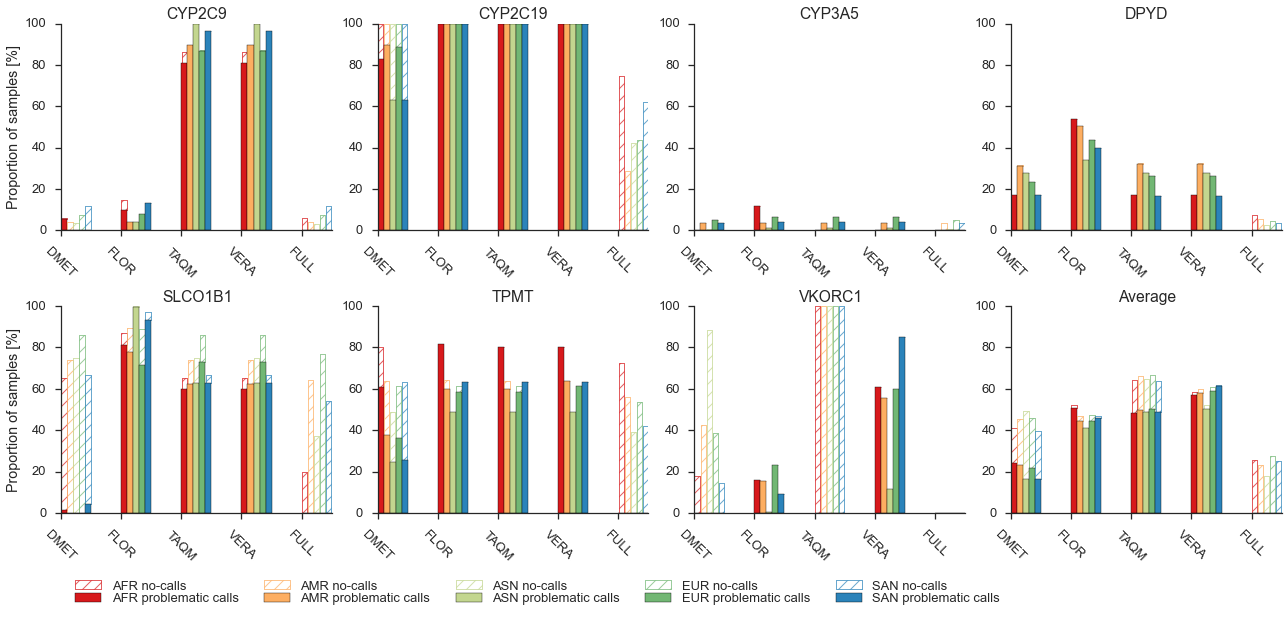

In [20]:
# prepare plotting
order = ['dmet_plus', 'florida_stanford_chip', 'taqman', 'veracode_adme_corepanel', 'hypothetical_assay_covering_all_rsids_in_pharmgkb']
afr_bogus_bar, afr_no_bar, amr_bogus_bar, amr_no_bar, asn_bogus_bar, asn_no_bar, eur_bogus_bar, eur_no_bar, san_bogus_bar, san_no_bar = [None] * 10

# plots the barchart for a single gene
def plot_calls(gene, pos):
    global afr_bogus_bar, afr_no_bar, amr_bogus_bar, amr_no_bar, asn_bogus_bar, asn_no_bar, eur_bogus_bar, eur_no_bar, san_bogus_bar, san_no_bar
    afr_bogus = np.array([bogus_calls[gene]['AFR'][o] for o in order])
    afr_no    = np.array([no_calls[gene]['AFR'][o] for o in order])
    amr_bogus = np.array([bogus_calls[gene]['AMR'][o] for o in order])
    amr_no    = np.array([no_calls[gene]['AMR'][o] for o in order])
    asn_bogus = np.array([bogus_calls[gene]['ASN'][o] for o in order])
    asn_no    = np.array([no_calls[gene]['ASN'][o] for o in order])
    eur_bogus = np.array([bogus_calls[gene]['EUR'][o] for o in order])
    eur_no    = np.array([no_calls[gene]['EUR'][o] for o in order])
    san_bogus = np.array([bogus_calls[gene]['SAN'][o] for o in order])
    san_no    = np.array([no_calls[gene]['SAN'][o] for o in order])

    afr_color = '#d7191c'
    amr_color = '#fdae61'
    asn_color = '#c3d68f'
    eur_color = '#72b774'
    san_color = '#2b83ba'

    with sns.axes_style("white"):
        sns.set_style("ticks")
        sns.set_context("talk")
        plt.subplot(240 + pos)
        plt.ylim(0, 100.0)
        plt.title(gene)

        # plot details
        bar_width = 0.1
        epsilon = 0.01
        line_width = 1
        opacity = 0.7
        afr_bar_positions = np.arange(len(afr_bogus))
        amr_bar_positions = afr_bar_positions + bar_width
        asn_bar_positions = amr_bar_positions + bar_width
        eur_bar_positions = asn_bar_positions + bar_width
        san_bar_positions = eur_bar_positions + bar_width

        # plot no-call bars before problematic bars because of transparency
        afr_no_bar = plt.bar(afr_bar_positions + epsilon/2, afr_no, bar_width-epsilon,
                             bottom=afr_bogus,
                             alpha=opacity,
                             color='white',
                             edgecolor=afr_color,
                             linewidth=line_width,
                             hatch='//',
                             label='AFR no-calls')
        afr_bogus_bar = plt.bar(afr_bar_positions, afr_bogus, bar_width,
                                color=afr_color,
                                label='AFR problematic calls')
        amr_no_bar = plt.bar(amr_bar_positions + epsilon/2, amr_no, bar_width-epsilon,
                             bottom=amr_bogus,
                             alpha=opacity,
                             color='white',
                             edgecolor=amr_color,
                             linewidth=line_width,
                             hatch='//',
                             label='AMR no-calls')
        amr_bogus_bar = plt.bar(amr_bar_positions, amr_bogus, bar_width,
                                color=amr_color,
                                label='AMR problematic calls')
        asn_no_bar = plt.bar(asn_bar_positions + epsilon/2, asn_no, bar_width-epsilon,
                             bottom=asn_bogus,
                             alpha=opacity,
                             color='white',
                             edgecolor=asn_color,
                             linewidth=line_width,
                             hatch='//',
                             label='ASN no-calls')
        asn_bogus_bar = plt.bar(asn_bar_positions, asn_bogus, bar_width,
                                color=asn_color,
                                label='ASN problematic calls')
        eur_no_bar = plt.bar(eur_bar_positions + epsilon/2, eur_no, bar_width-epsilon,
                             bottom=eur_bogus,
                             alpha=opacity,
                             color='white',
                             edgecolor=eur_color,
                             linewidth=line_width,
                             hatch='//',
                             label='EUR no-calls')
        eur_bogus_bar = plt.bar(eur_bar_positions, eur_bogus, bar_width,
                                color=eur_color,
                                label='EUR problematic calls')
        san_no_bar = plt.bar(san_bar_positions + epsilon/2, san_no, bar_width-epsilon,
                             bottom=san_bogus,
                             alpha=opacity,
                             color='white',
                             edgecolor=san_color,
                             linewidth=line_width,
                             hatch='//',
                             label='SAN no-calls')
        san_bogus_bar = plt.bar(san_bar_positions, san_bogus, bar_width,
                                color=san_color,
                                label='SAN problematic calls')

        plt.xticks(afr_bar_positions, [ABBR[o] for o in order], rotation = -45)
        if pos in [1, 5]:  # add y-axis label to leftmost subplots
            plt.ylabel('Proportion of samples [%]')
        if pos is 7:       # clear the last subplot
            plt.subplot(248)
            plt.delaxes(fig.axes[7])
        sns.despine()

# prepare a figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))

# plot genes data
for i, gene in enumerate(GENES):
    plot_calls(gene, i + 1)
# plot average across all genes data
plot_calls("Average", 8)

# add a legend
legend = pylab.legend(loc = 'lower right', ncol = 5, bbox_to_anchor = (0.0, -0.5), labelspacing = 0.0)
# layout
fig.tight_layout()

# save the figure to file
plt.savefig('output/call_percentages_by_gene.png', dpi=300, bbox_inches="tight")

### Data export

In [21]:
# collect haplotype results for each sample
results_by_sample = prettydefaultdict(lambda: prettydefaultdict(list))

for result in results:
    haplotype = result['haplotype_calls_hypothetical_assay_covering_all_rsids_in_pharmgkb']
    results_by_sample[result['sample']][result['gene']].append(haplotype)

    
# write haplotype results for all samples to csv file
with open('output/all_haplotypes_by_sample.csv', 'w', newline='') as f:
    def get_haplotype_from_set(s):
        """Return a single haplotype from a set of haplotypes, or "*1" if the set is empty."""
        # return *1 if it is in the set or if no haplotype definition is possible (empty set)
        if len(s) == 0 or "*1" in s:
            return "*1"
        # otherwise return a random item from the set
        else:
            return list(s)[0]
    
    w = csv.writer(f, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
    
    w.writerow(['Sample'] + GENES)  # header
    # collect data & write body
    for sample, data in results_by_sample.items():
        row = [sample]  # first column is the sample id
        for gene in GENES:
            haplotypes = map(get_haplotype_from_set, data[gene])
            row.append('|'.join(haplotypes))
    
        w.writerow(row)